In [40]:
import requests
import os
import io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.neighbors import KNeighborsClassifier as KNN_Class
from sklearn.metrics import classification_report as rep
from sklearn.model_selection import GridSearchCV as gscv
from sklearn.metrics import mean_squared_error as mse
from sklearn.neighbors import KNeighborsRegressor as KNN_Reg

import warnings
warnings.simplefilter(action='ignore')

In [41]:
url = "https://raw.githubusercontent.com/joepollastrini/Loan-Prediction/master"
train_name = 'train_loan_data.csv'
test_name = 'test_loan_data.csv'

In [42]:
def data_grab_online(base, name, out='output.csv'):
    #get data from url
    u = base + '/' + name
    r = requests.get(u).content
    df = pd.read_csv(u)
    return df

In [43]:
train = data_grab_online(url, train_name)
test = data_grab_online(url, test_name)

Clean like normal, don't clean anything that mode was used as imputation.  If any feature engineering was used from these imputed variables.  Keep them out until imputed.

In [44]:
def gender_impute_and_dummy(row):
    #if unmarried and 1 dependent female, else male
    if pd.isnull(row['Gender']):
        if row['Married'] == 'No' and row['Dependents'] == '1':
            return 0
        else:
            return 1
    else:
        if row['Gender'] == 'Male':
            return 1
        else:
            return 0
        
train['Male_IO'] = train.apply(lambda x: gender_impute_and_dummy(x), axis=1)
train.drop(columns = ['Gender'], inplace=True)

test['Male_IO'] = test.apply(lambda x: gender_impute_and_dummy(x), axis=1)
test.drop(columns = ['Gender'], inplace = True)

In [45]:
def married_impute_and_dummy(x):
    #if female, not married, otherwise married
    if pd.isnull(x['Married']):
        if x['Male_IO'] == 0:
            return 0
        else:
            return 1
    else:
        if x['Married'] == 'Yes':
            return 1
        else:
            return 0
        
train['Married_IO'] = train.apply(lambda x: married_impute_and_dummy(x), axis=1)
train.drop(columns = ['Married'], inplace=True)

test['Married_IO'] = test.apply(lambda x: married_impute_and_dummy(x), axis=1)
test.drop(columns = ['Married'], inplace = True)

In [46]:
def dependents_impute_and_ordinal(x):
    #if married, one dependent, otherwise none
    #convert dependents to ordinal int as well
    if pd.isnull(x['Dependents']):
        if x['Married_IO'] == 1:
            return 1
        else:
            return 0
    elif x['Dependents'] == '3+':
        return 3
    else:
        return int(x['Dependents'])
    
    
train['Dependents_Ord'] = train.apply(lambda x: dependents_impute_and_ordinal(x), axis=1)
train.drop(columns = ['Dependents'], inplace=True)

test['Dependents_Ord'] = test.apply(lambda x: dependents_impute_and_ordinal(x), axis=1)
test.drop(columns = ['Dependents'], inplace = True)

In [47]:
def dual_income_dummy(x):
    if x['Married_IO'] == 1:
        if x['CoapplicantIncome'] > 0:
            return 1
        else:
            return 0
    else:
        return 0

In [48]:
def clean(df):
    col_drop = []
    col_rename = {}
    
    # FAMILY SIZE #
    df['FamilySize'] = df['Dependents_Ord'] + df['Married_IO'] + 1
        
    # EDUCATION #
    df['Education_IO'] = df['Education'].apply(lambda x: 1 if x == 'Graduate' else 0)
    col_drop.append('Education')

    # INCOME #
    df['FamilyIncome'] = df['ApplicantIncome'] + df['CoapplicantIncome']
    df['DualIncome_IO'] = df.apply(lambda x: dual_income_dummy(x), axis=1)
    col_drop.extend(['ApplicantIncome', 'CoapplicantIncome'])
    
    # PROPERTY AREA #
    df['PA_Urban'] = df['Property_Area'].apply(lambda x: 1 if x == 'Urban' else 0)
    df['PA_Rural'] = df['Property_Area'].apply(lambda x: 1 if x == 'Rural' else 0)
    df['PA_Semiurban'] = df['Property_Area'].apply(lambda x: 1 if x == 'Semiurban' else 0)
    col_drop.append('Property_Area')
    
    # INCOME PER FAMILY MEMBER #
    df['IncomePerMember'] = df['FamilyIncome'] / df['FamilySize']
    
    #column cleaning
    df.drop(columns = col_drop, inplace=True)
    df.rename(columns=col_rename, inplace=True)
    return df

In [49]:
train_clean = clean(train)
test_clean = clean(test)

Build Loan Term Amount model and use to impute

In [50]:
def loan_group(x):
    if np.isnan(x):
        return x
    else:
        x = int(x)
        if x == 360:
            return '30'
        elif x == 180:
            return '15'
        elif x < 180:
            return '<15'
        elif x > 180 and x < 360:
            return '(15, 30)'
        elif x > 360:
            return '>30'
        else:
            return x

In [51]:
def knn_loan_term_model(train, x_cols, k):
    model = KNN_Class(n_neighbors = k)
    
    x = train[x_cols]
    y = train['LoanTermGroups']
    
    model.fit(x, y)
    return model

In [52]:
def LTA_predict(model, row, x_cols):
    valueList = []
    for col in x_cols:
        value = row[col]
        valueList.append(value)

    df = pd.DataFrame([valueList])
    
    prediction = model.predict(df)[0]
    return prediction

In [53]:
def clean2(df, model):
    #group loan terms, don't change nan values
    df['LoanTermGroups'] = df['Loan_Amount_Term'].apply(lambda x: loan_group(x))
    
    #create predictions using model
    df['LTA_Predict'] = df.apply(lambda x: LTA_predict(LTA_model, x, LTA_knn_cols), axis=1)
    
    #replace missing values from loan term groups with predicted values
    df['LoanTermGroups'].fillna(df['LTA_Predict'], inplace=True)
    
    df.drop(columns = ['Loan_Amount_Term', 'LTA_Predict'], inplace=True)
    return df

In [54]:
train_LTA = train_clean.dropna(subset = ['Self_Employed', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History'])
train_LTA['LoanTermGroups'] = train_LTA['Loan_Amount_Term'].apply(lambda x: loan_group(x))

LTA_knn_cols = ['IncomePerMember', 'FamilyIncome']
LTA_k = 7

In [55]:
LTA_model = knn_loan_term_model(train_LTA, LTA_knn_cols, LTA_k)

In [56]:
train_clean2 = clean2(train_clean, LTA_model)
test_clean2 = clean2(test_clean, LTA_model)

In [57]:
nans = train_clean2.isna().sum()
nans = nans.loc[nans > 0]
nans

Self_Employed     32
LoanAmount        22
Credit_History    50
dtype: int64

***
## Loan Amount Imputation

In [76]:
train_LA = train_clean2.dropna(subset = ['Self_Employed', 'LoanAmount', 'Credit_History'])
train_LA['LoanAmountLog'] = np.log(train_LA['LoanAmount'].astype('float64'))
train_LA['Self_Employed_IO'] = train_LA['Self_Employed'].apply(lambda x: 1 if x=='Yes' else 0)
train_LA['LTG_<15'] = train_LA['LoanTermGroups'].apply(lambda x: 1 if x == '<15' else 0)
train_LA['LTG_15'] = train_LA['LoanTermGroups'].apply(lambda x: 1 if x == '15' else 0)
train_LA['LTG_1530'] = train_LA['LoanTermGroups'].apply(lambda x: 1 if x == '(15, 30)' else 0)
train_LA['LTG_30'] = train_LA['LoanTermGroups'].apply(lambda x: 1 if x == '30' else 0)
train_LA['LTG_>30'] = train_LA['LoanTermGroups'].apply(lambda x: 1 if x == '>30' else 0)

test_LA = test_clean2.dropna(subset = ['Self_Employed', 'LoanAmount', 'Credit_History'])
test_LA['LoanAmountLog'] = np.log(test_LA['LoanAmount'].astype('float64'))
test_LA['Self_Employed_IO'] = test_LA['Self_Employed'].apply(lambda x: 1 if x=='Yes' else 0)
test_LA['LTG_<15'] = test_LA['LoanTermGroups'].apply(lambda x: 1 if x == '<15' else 0)
test_LA['LTG_15'] = test_LA['LoanTermGroups'].apply(lambda x: 1 if x == '15' else 0)
test_LA['LTG_1530'] = test_LA['LoanTermGroups'].apply(lambda x: 1 if x == '(15, 30)' else 0)
test_LA['LTG_30'] = test_LA['LoanTermGroups'].apply(lambda x: 1 if x == '30' else 0)
test_LA['LTG_>30'] = test_LA['LoanTermGroups'].apply(lambda x: 1 if x == '>30' else 0)

## Method 1:
replace nan values with mean for loan term group

In [77]:
group = train_LA.groupby(['LoanTermGroups'])['LoanAmountLog'].mean().to_dict()

In [78]:
train_LA['M1 Pred'] = train_LA['LoanTermGroups'].apply(lambda x: group[x])
test_LA['M1 Pred'] = test_LA['LoanTermGroups'].apply(lambda x: group[x])
bench_train = mse(train_LA['LoanAmountLog'], train_LA['M1 Pred'])
bench_test = mse(test_LA['LoanAmountLog'], test_LA['M1 Pred'])
print(bench_train)
print(bench_test)

0.24806627646772436
0.172010998369502


## Method 2:
KNN Regression

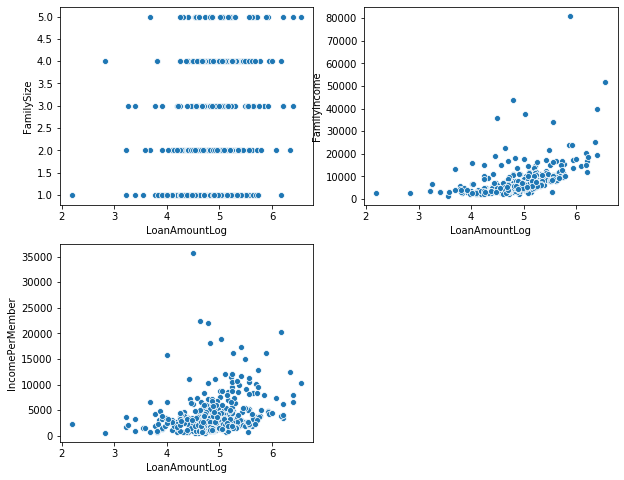

In [79]:
fig = plt.figure(figsize=(10,8))
ax1 = fig.add_subplot(2,2,1)
sns.scatterplot(train_LA['LoanAmountLog'], train_LA['FamilySize']);

ax2 = fig.add_subplot(2,2,2)
sns.scatterplot(train_LA['LoanAmountLog'], train_LA['FamilyIncome']);

ax3 = fig.add_subplot(2,2,3)
sns.scatterplot(train_LA['LoanAmountLog'], train_LA['IncomePerMember']);

In [80]:
m2 = KNN_Reg(n_neighbors = 5)
m2.fit(train_LA[['FamilyIncome']], train_LA['LoanAmountLog'])

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                    weights='uniform')

In [81]:
preds = m2.predict(train_LA[['FamilyIncome']])
predictions = pd.DataFrame(preds, columns=['Predictions'])
y_act = train_LA['LoanAmountLog'].reset_index(drop=True, inplace=True)
toScore = pd.concat((predictions, train_LA['LoanAmountLog']), axis=1)
train_score = mse(toScore['LoanAmountLog'], toScore['Predictions'])
print(train_score)

0.11363727907628939


In [92]:
def knn_la(train, test, x_cols, y):
    print(x_cols)
    x_train = train[x_cols]
    y_train = train[y]
    x_test = test[x_cols]
    y_test = test[y]
    
    #determine best k value
    hyperparameters = dict(n_neighbors = list(range(2, 60)))
    knn_cv = KNN_Reg()
    models = gscv(knn_cv, hyperparameters, cv=10)
    best_model = models.fit(x_train, y_train)
    k = best_model.best_estimator_.get_params()['n_neighbors']
    print('Optimized k:  {}'.format(k))
    
    #fit model
    model = KNN_Reg(n_neighbors = k)
    model.fit(x_train, y_train)
    
    ## training set predictions and score ##
    print(' *** Training *** ')
    trainPreds = model.predict(x_train)
    trainPredictions = pd.DataFrame(trainPreds, columns = ['Predicted'])
    y_train.reset_index(drop=True, inplace=True)
    trainScoring = pd.concat((y_train, trainPredictions), axis=1)
    train_score = mse(trainScoring[y], trainScoring['Predicted'])
    print('Train MSE:  {}'.format(train_score))
    
    ## testing set predictions and score ##
    print(' *** Testing *** ')
    testPreds = model.predict(x_test)
    testPredictions = pd.DataFrame(testPreds, columns = ['Predicted'])
    y_test.reset_index(drop=True, inplace=True)
    testScoring = pd.concat((y_test, testPredictions), axis=1)
    test_score = mse(testScoring[y], testScoring['Predicted'])
    print('Test MSE:  {}'.format(test_score))
    print('****************************************')
    
    return model

In [84]:
allScores = [['all', bench_train, bench_test, (bench_test-bench_train)]]
for c in ['Credit_History', 'Male_IO', 'Married_IO', 'FamilySize', 'Education_IO', 'FamilyIncome', 'DualIncome_IO'
         ,['PA_Urban', 'PA_Rural'], 'IncomePerMember', ['LTG_<15', 'LTG_15', 'LTG_1530', 'LTG_30'], 'Self_Employed_IO']:
    if type(c) == str:
        scores = knn_la(train_LA, test_LA, [c], 'LoanAmountLog')
    else:
        scores = knn_la(train_LA, test_LA, c, 'LoanAmountLog')
    allScores.append(scores)

['Credit_History']
Optimized k:  57
 *** Training *** 
Train MSE:  0.25702738749102144
 *** Testing *** 
Test MSE:  0.1752812310997264
****************************************
['Male_IO']
Optimized k:  57
 *** Training *** 
Train MSE:  0.25020920323313744
 *** Testing *** 
Test MSE:  0.17424436033571988
****************************************
['Married_IO']
Optimized k:  58
 *** Training *** 
Train MSE:  0.24530114478246837
 *** Testing *** 
Test MSE:  0.1692713327668537
****************************************
['FamilySize']
Optimized k:  54
 *** Training *** 
Train MSE:  0.24131003435362217
 *** Testing *** 
Test MSE:  0.17466207539760484
****************************************
['Education_IO']
Optimized k:  50
 *** Training *** 
Train MSE:  0.25448414045545437
 *** Testing *** 
Test MSE:  0.17490587549803857
****************************************
['FamilyIncome']
Optimized k:  46
 *** Training *** 
Train MSE:  0.13903186500037212
 *** Testing *** 
Test MSE:  0.10758542312000027


In [85]:
allScores

[['all', 0.24806627646772436, 0.172010998369502, -0.07605527809822235],
 [57, 0.25702738749102144, 0.1752812310997264, -0.08174615639129504],
 [57, 0.25020920323313744, 0.17424436033571988, -0.07596484289741756],
 [58, 0.24530114478246837, 0.1692713327668537, -0.07602981201561468],
 [54, 0.24131003435362217, 0.17466207539760484, -0.06664795895601733],
 [50, 0.25448414045545437, 0.17490587549803857, -0.0795782649574158],
 [46, 0.13903186500037212, 0.10758542312000027, -0.03144644188037185],
 [39, 0.2590216076381408, 0.17758433966104012, -0.08143726797710069],
 [21, 0.25183944904699573, 0.17917925621384284, -0.07266019283315289],
 [58, 0.22414711348303695, 0.1534848538216954, -0.07066225966134154],
 [33, 0.250946611418978, 0.17064316964168835, -0.08030344177728965],
 [32, 0.25261122002107106, 0.17157269254742386, -0.0810385274736472]]

In [86]:
bench2 = knn_la(train_LA, test_LA, ['FamilyIncome'], 'LoanAmountLog')

['FamilyIncome']
Optimized k:  46
 *** Training *** 
Train MSE:  0.13903186500037212
 *** Testing *** 
Test MSE:  0.10758542312000027
****************************************


In [87]:
knn_la(train_LA, test_LA, ['IncomePerMember'], 'LoanAmountLog')

['IncomePerMember']
Optimized k:  58
 *** Training *** 
Train MSE:  0.22414711348303695
 *** Testing *** 
Test MSE:  0.1534848538216954
****************************************


[58, 0.22414711348303695, 0.1534848538216954, -0.07066225966134154]

In [88]:
knn_la(train_LA, test_LA, ['FamilySize'], 'LoanAmountLog')

['FamilySize']
Optimized k:  54
 *** Training *** 
Train MSE:  0.24131003435362217
 *** Testing *** 
Test MSE:  0.17466207539760484
****************************************


[54, 0.24131003435362217, 0.17466207539760484, -0.06664795895601733]

In [89]:
knn_la(train_LA, test_LA, ['Married_IO'], 'LoanAmountLog')

['Married_IO']
Optimized k:  58
 *** Training *** 
Train MSE:  0.24530114478246837
 *** Testing *** 
Test MSE:  0.1692713327668537
****************************************


[58, 0.24530114478246837, 0.1692713327668537, -0.07602981201561468]

Best model uses FamilyIncome, start with that and look to improve.  Start with IncomePerMember, FamilySize, Married, LTGs, PAs, Male, and Credit_History

In [90]:
allScores = [[46, bench2[1], bench2[2], (bench2[2]-bench2[1])]]
for c in ['IncomePerMember', 'FamilySize', 'Married_IO'
          ,['LTG_<15', 'LTG_15', 'LTG_1530', 'LTG_30'], ['PA_Urban', 'PA_Rural']
         ,'Male_IO', 'Credit_History']:
    if type(c) == str:
        scores = knn_la(train_LA, test_LA, ['FamilyIncome', c], 'LoanAmountLog')
    else:
        scores = knn_la(train_LA, test_LA, ['FamilyIncome'] + c, 'LoanAmountLog')
    allScores.append(scores)

['FamilyIncome', 'IncomePerMember']
Optimized k:  24
 *** Training *** 
Train MSE:  0.13194544786400697
 *** Testing *** 
Test MSE:  0.11289478209514421
****************************************
['FamilyIncome', 'FamilySize']
Optimized k:  52
 *** Training *** 
Train MSE:  0.1394718986150981
 *** Testing *** 
Test MSE:  0.1069653283305002
****************************************
['FamilyIncome', 'Married_IO']
Optimized k:  52
 *** Training *** 
Train MSE:  0.13946979864324835
 *** Testing *** 
Test MSE:  0.1069861386897735
****************************************
['FamilyIncome', 'LTG_<15', 'LTG_15', 'LTG_1530', 'LTG_30']
Optimized k:  52
 *** Training *** 
Train MSE:  0.13933256922150275
 *** Testing *** 
Test MSE:  0.10693569028546843
****************************************
['FamilyIncome', 'PA_Urban', 'PA_Rural']
Optimized k:  46
 *** Training *** 
Train MSE:  0.13908293384283557
 *** Testing *** 
Test MSE:  0.10762549318607205
****************************************
['FamilyIncome

In [91]:
allScores

[[46, 0.13903186500037212, 0.10758542312000027, -0.03144644188037185],
 [24, 0.13194544786400697, 0.11289478209514421, -0.01905066576886276],
 [52, 0.1394718986150981, 0.1069653283305002, -0.0325065702845979],
 [52, 0.13946979864324835, 0.1069861386897735, -0.03248365995347485],
 [52, 0.13933256922150275, 0.10693569028546843, -0.03239687893603432],
 [46, 0.13908293384283557, 0.10762549318607205, -0.03145744065676352],
 [46, 0.13899666800294727, 0.10753120954734005, -0.03146545845560722],
 [47, 0.1394651238665518, 0.10751972301773918, -0.031945400848812616]]

Best models: FamilySize, Married, LTG.

Use FamilyIncome and the LTG dummy variables to estimate the log of missing loan amount values

In [95]:
direct = os.getcwd()
print(direct)

C:\Users\joepo\Desktop


In [93]:
m = knn_la(train_LA, test_LA, ['FamilyIncome', 'LTG_<15', 'LTG_15', 'LTG_1530', 'LTG_30'], 'LoanAmountLog')

['FamilyIncome', 'LTG_<15', 'LTG_15', 'LTG_1530', 'LTG_30']
Optimized k:  52
 *** Training *** 
Train MSE:  0.13933256922150275
 *** Testing *** 
Test MSE:  0.10693569028546843
****************************************


In [94]:
fname = 'knn_Loan_Amount.sav'

In [98]:
pickle.dump(m, open(os.path.join(direct, 'Project Portfolio', 'Loan Prediction', 'Models', fname), 'wb'))

In [97]:
import pickle